# NovaPay Feature Engineering

This notebook starts from the cleaned NovaPay dataset and creates additional model-ready features:

- Time-based signals (hour, weekday, weekend, night)
- Ratios (velocity ratio, fee ratio)
- Interactions (amount × velocity, device trust × IP risk)
- Simple binary flags (risk rules)
- Outlier handling (capping + log transforms)

Finally, it saves an engineered CSV for modeling and deployment.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 5)
sns.set_style("whitegrid")

print("✅ Libraries loaded")


✅ Libraries loaded


## Load cleaned dataset

In [5]:
# Change this if your cleaned file name/path is different
DATA_PATH = "/content/sample_data/Nova_CleanedEDA_df.csv"

df = pd.read_csv(DATA_PATH)
print("📌 Shape:", df.shape)
display(df.head())


📌 Shape: (11137, 26)


,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,...,ip_risk_score,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud
0,a3d2ad59-8e0f-4b33-b9cf-48bdca536e2f,22c3f4f2-23a3-4f40-adc0-307dff722216,2023-12-03 01:18:32.573611+00:00,UK,GBP,NGN,WEB,2267.24,2834.05,34.35,...,0.929,LOW,24,0.027,1,0.312,8,11,0.22,1
1,ff87e7e7-7647-4059-8691-1a6d3e5251c2,db2b26f9-e12f-49d9-bf2f-73ae77a0d81f,2023-12-03 13:05:30.573611+00:00,US,USD,NGN,WEB,624.63,624.63,9.78,...,1.000,LOW,14,0.566,0,0.311,6,7,0.00,1
2,5664b84f-2c90-4539-a5d9-6ec3bec881c5,74224638-f8fd-4ca1-91b0-244ffb6f7310,2023-12-05 03:38:56.573611+00:00,CA,CAD,INR,WEB,642.36,475.35,11.43,...,1.000,LOW,65,0.386,1,0.425,7,8,0.12,1
3,771f1ad8-3902-4531-bb3c-6a4fa37ae438,93ca016d-93a2-4b86-b170-8871a9e4561e,2023-12-05 14:58:16.573611+00:00,US,USD,PHP,WEB,938.16,938.16,14.58,...,1.000,LOW,29,0.337,2,0.758,6,7,0.10,1
4,41dffb0b-2515-46ff-814c-724fa0f50c99,6ab3647c-b86e-4018-8fba-4077e0bf986a,2023-12-06 13:59:05.573611+00:00,US,USD,MXN,MOBILE,114.51,114.51,1.97,...,0.254,STANDARD,1095,0.566,0,0.225,1,2,0.00,0


## Quick checks

In [6]:
df.info()
print("\nFraud rate:", round(df["is_fraud"].mean(), 4))
display(df.isna().sum().sort_values(ascending=False).head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11137 entries, 0 to 11136
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   transaction_id             11137 non-null  object 
 1   customer_id                11137 non-null  object 
 2   timestamp                  11137 non-null  object 
 3   home_country               11137 non-null  object 
 4   source_currency            11137 non-null  object 
 5   dest_currency              11137 non-null  object 
 6   channel                    11137 non-null  object 
 7   amount_src                 11137 non-null  float64
 8   amount_usd                 11137 non-null  float64
 9   fee                        11137 non-null  float64
 10  exchange_rate_src_to_dest  11137 non-null  float64
 11  device_id                  11137 non-null  object 
 12  new_device                 11137 non-null  int64  
 13  ip_address                 11137 non-null  obj

,0
transaction_id,0
customer_id,0
timestamp,0
home_country,0
source_currency,0
dest_currency,0
channel,0
amount_src,0
amount_usd,0
fee,0


## Time features

In [7]:
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)

df["hour"] = df["timestamp"].dt.hour.astype("int32")
df["day_of_week"] = df["timestamp"].dt.dayofweek.astype("int32")
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype("int32")
df["is_night"] = df["hour"].between(2, 8).astype("int32")

def time_bucket(h):
    if h < 6:
        return "late_night"
    if h < 12:
        return "morning"
    if h < 18:
        return "afternoon"
    return "evening"

df["time_bucket"] = df["hour"].apply(time_bucket)

display(df[["timestamp","hour","day_of_week","is_weekend","is_night","time_bucket"]].head())


,timestamp,hour,day_of_week,is_weekend,is_night,time_bucket
0,2023-12-03 01:18:32.573611+00:00,1,6,1,0,late_night
1,2023-12-03 13:05:30.573611+00:00,13,6,1,0,afternoon
2,2023-12-05 03:38:56.573611+00:00,3,1,0,1,late_night
3,2023-12-05 14:58:16.573611+00:00,14,1,0,0,afternoon
4,2023-12-06 13:59:05.573611+00:00,13,2,0,0,afternoon


## Corridor + frequency features

In [8]:
df["currency_pair"] = df["source_currency"].astype(str) + "_" + df["dest_currency"].astype(str)

# Count how often the same IP appears
df["ip_usage_count"] = df.groupby("ip_address")["transaction_id"].transform("count").astype("int32")

display(df[["currency_pair","ip_address","ip_usage_count"]].head())


,currency_pair,ip_address,ip_usage_count
0,GBP_NGN,152.53.166.148,1
1,USD_NGN,18.80.215.171,1
2,CAD_INR,81.208.70.115,1
3,USD_PHP,61.215.208.241,1
4,USD_MXN,137.84.59.231,1


## Ratios + interactions

In [9]:
df["velocity_ratio"] = df["txn_velocity_1h"] / (df["txn_velocity_24h"] + 1)

df["fee_ratio"] = df["fee"] / df["amount_usd"].replace(0, np.nan)
df["fee_ratio"] = df["fee_ratio"].fillna(0)

df["new_device_risk"] = df["new_device"].astype(int) * (1 - df["device_trust_score"])

df["amount_x_velocity"] = df["amount_usd"] * df["velocity_ratio"]
df["device_x_ip_risk"] = df["device_trust_score"] * df["ip_risk_score"]
df["new_device_x_vel1h"] = df["new_device"].astype(int) * df["txn_velocity_1h"]

display(df[[
    "velocity_ratio","fee_ratio","new_device_risk",
    "amount_x_velocity","device_x_ip_risk","new_device_x_vel1h"
]].head())


,velocity_ratio,fee_ratio,new_device_risk,amount_x_velocity,device_x_ip_risk,new_device_x_vel1h
0,0.666667,0.012120,0.973,1889.366667,0.025083,8
1,0.750000,0.015657,0.000,468.472500,0.566000,0
2,0.777778,0.024045,0.000,369.716667,0.386000,0
3,0.750000,0.015541,0.000,703.620000,0.337000,0
4,0.333333,0.017204,0.000,38.170000,0.143764,0


## Binary risk flags

In [10]:
df["flag_new_device_high_velocity"] = (
    (df["new_device"].astype(int) == 1) & (df["txn_velocity_1h"] >= 3)
).astype("int32")

df["flag_young_account_high_amount"] = (
    (df["account_age_days"] < 30) & (df["amount_usd"] > 500)
).astype("int32")

df["flag_ip_risk_and_location_mismatch"] = (
    (df["ip_risk_score"] > 0.7) & (df["location_mismatch"].astype(int) == 1)
).astype("int32")

display(df[[
    "flag_new_device_high_velocity",
    "flag_young_account_high_amount",
    "flag_ip_risk_and_location_mismatch"
]].head())


,flag_new_device_high_velocity,flag_young_account_high_amount,flag_ip_risk_and_location_mismatch
0,1,1,0
1,0,1,1
2,0,0,0
3,0,1,0
4,0,0,0


## Outliers + transforms

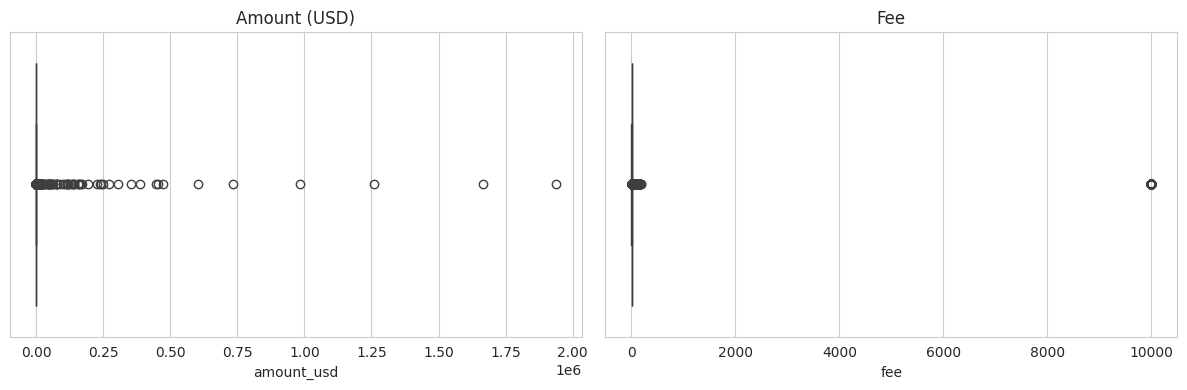

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df["amount_usd"], ax=ax[0])
ax[0].set_title("Amount (USD)")

sns.boxplot(x=df["fee"], ax=ax[1])
ax[1].set_title("Fee")
plt.tight_layout()
plt.show()


In [12]:
cap_q = 0.99
amount_cap = df["amount_usd"].quantile(cap_q)
df["amount_usd_capped"] = df["amount_usd"].clip(upper=amount_cap)

df["log_amount_usd"] = np.log1p(df["amount_usd_capped"].clip(lower=0))
df["log_fee"] = np.log1p(df["fee"].clip(lower=0))

display(df[["amount_usd","amount_usd_capped","log_amount_usd","fee","log_fee"]].head())


,amount_usd,amount_usd_capped,log_amount_usd,fee,log_fee
0,2834.05,2834.05,7.949815,34.35,3.565298
1,624.63,624.63,6.438759,9.78,2.377693
2,475.35,475.35,6.166153,11.43,2.520113
3,938.16,938.16,6.844986,14.58,2.745988
4,114.51,114.51,4.749357,1.97,1.088562


## Save engineered dataset

In [15]:
import os

OUTPUT_PATH = "../data/Nova_Features_Engineered.csv"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

df.to_csv(OUTPUT_PATH, index=False)

print("✅ Saved:", OUTPUT_PATH)
print("📌 Final shape:", df.shape)

✅ Saved: ../data/Nova_Features_Engineered.csv
📌 Final shape: (11137, 45)
